# LaunchDarkly Percentage Rollout Simulator

## Setup
If you want to use all visualizations (including the Sankey diagram), install required dependencies:
```bash
pip install -r requirements.txt
```

In [1]:
import ldclient
from ldclient import Context
from ldclient.config import Config
from faker import Faker
from uuid import uuid4
from faker.providers import DynamicProvider 
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional imports for Sankey diagram
try:
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False

In [2]:
# Initialize LaunchDarkly client
sdk_key = 'sdk-c6b1251d-06e7-4efd-9486-2c51570cc5d3'
config = Config(sdk_key = sdk_key, http=ldclient.config.HTTPConfig(connect_timeout=5))
ldclient.set_config(config)
client = ldclient.get()

In [3]:
def parse_string_to_dict(item):
    clean_item = item.strip("()")
    key_value_pairs = clean_item.split(", ")
    parsed_dict = {}
    for pair in key_value_pairs:
        key, value = pair.split("=")
        parsed_dict[key.strip()] = value.strip()
    return parsed_dict

In [4]:
# Set up Faker providers
brands_provider = DynamicProvider(
    provider_name="brand",
    elements=["Admiral", "Diamond", "Elephant", "Toothbrush", "Biscuit"],
)

product_provider = DynamicProvider(
    provider_name="product",
    elements=["Car", "Home", "Motorcycle", "Renters"],
)

price_provider = DynamicProvider(
    provider_name="example_in_cart_price",
    elements=[93.84, 143.73, 101.35, 86.02, 46.91, 125.62, 77.85, 99.68, 73.99, 148.79],
)

tier_provider = DynamicProvider(
    provider_name="tier",
    elements=["Bronze", "Silver", "Gold"],
)

fake = Faker()
fake.add_provider(brands_provider)
fake.add_provider(price_provider)
fake.add_provider(product_provider)
fake.add_provider(tier_provider)

In [5]:
# Generate test data
num_records = 100
fakeUserId2 = [fake.uuid4() for _ in range(num_records + 1)]
user2Brand = [fake.brand() for _ in range(num_records + 1)]
user2Price = [fake.example_in_cart_price() for _ in range(num_records + 1)]
user2Product = [fake.product() for _ in range(num_records + 1)]
user2Tier = [fake.tier() for _ in range(num_records + 1)]

In [6]:
# First run
run1 = []
run1_control = []
run1_treatment = []
run1_keys = []

for i in range(num_records + 1):
    user2_context = Context.builder(fakeUserId2[i]).kind("user").set("brand", user2Brand[i]).set("product", user2Product[i]).set("tier", user2Tier[i]).build()
    variation_detail = client.variation_detail("example-percentage-rollout-flag", user2_context, 'false')
    run1_keys.append(user2_context.key)
    if (variation_detail.value == "Control"):
        run1_control.append(user2_context.key)
    else:
        run1_treatment.append(user2_context.key)
    time.sleep(0.01)
    run1.append(variation_detail)

### Change the percentage rollout in LaunchDarkly before running the next cell

In [7]:
# Second run
run2 = []
run2_control = []
run2_treatment = []
run2_keys = []

for i in range(num_records + 1):
    user2_context = Context.builder(fakeUserId2[i]).kind("user").set("brand", user2Brand[i]).set("product", user2Product[i]).set("tier", user2Tier[i]).build()
    variation_detail = client.variation_detail("example-percentage-rollout-flag", user2_context, 'false')
    run2_keys.append(user2_context.key)
    if (variation_detail.value == "Control"):
        run2_control.append(user2_context.key)
    else:
        run2_treatment.append(user2_context.key)
    time.sleep(0.01)
    run2.append(variation_detail)

In [8]:
# Create DataFrames and analyze changes
run1_parsed_data = [parse_string_to_dict(str(item)) for item in run1]
run2_parsed_data = [parse_string_to_dict(str(item)) for item in run2]
run1_df = pd.DataFrame(run1_parsed_data)
run2_df = pd.DataFrame(run2_parsed_data)
keys_df = pd.DataFrame(run1_keys, columns=['key'])
run1_df['key'] = keys_df['key']
run2_df['key'] = keys_df['key']
result = pd.merge(run1_df, run2_df, on='key')

# Find mismatches
mismatch = result[result['value_x'] != result['value_y']]
mismatchCount = len(mismatch)
print(f"Number of users that changed variations: {mismatchCount}")

Number of users that changed variations: 23


<Figure size 1200x600 with 0 Axes>

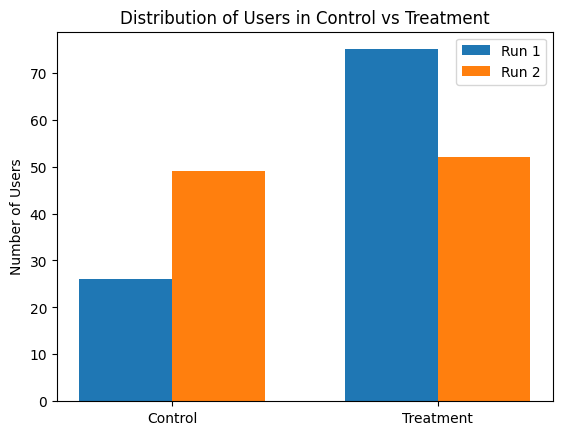

In [9]:
# Visualization 1: Distribution Comparison
plt.figure(figsize=(12, 6))
x = np.arange(2)
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, [len(run1_control), len(run1_treatment)], width, label='Run 1')
ax.bar(x + width/2, [len(run2_control), len(run2_treatment)], width, label='Run 2')

ax.set_ylabel('Number of Users')
ax.set_title('Distribution of Users in Control vs Treatment')
ax.set_xticks(x)
ax.set_xticklabels(['Control', 'Treatment'])
ax.legend()

plt.show()

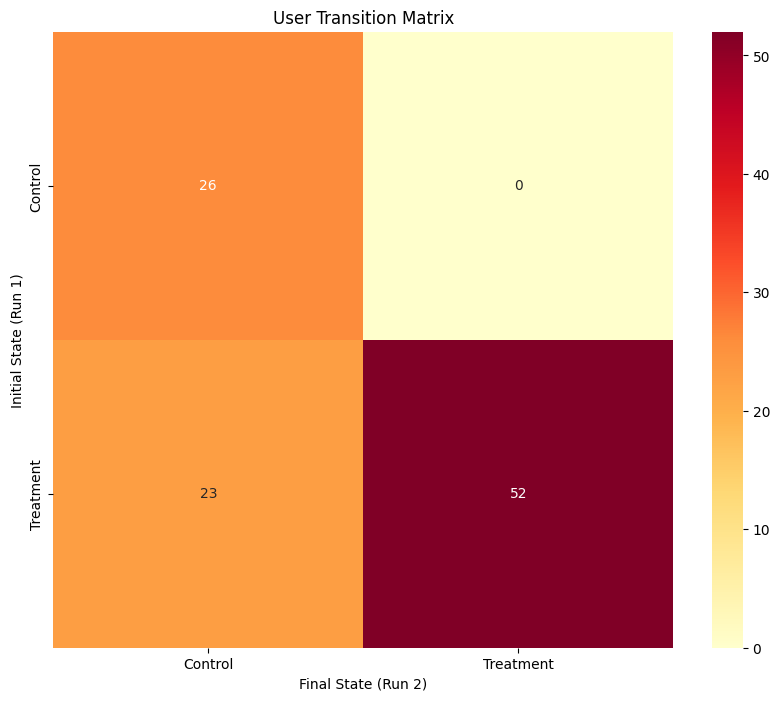

In [10]:
# Visualization 2: Transition Matrix Heatmap
transition_matrix = pd.crosstab(result['value_x'], result['value_y'])

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt='d', cmap='YlOrRd')
plt.title('User Transition Matrix')
plt.xlabel('Final State (Run 2)')
plt.ylabel('Initial State (Run 1)')
plt.show()

# Optional Sankey diagram if plotly is available
if PLOTLY_AVAILABLE:
    label_mapping = {'Control': 0, 'Treatment': 1}
    source = []
    target = []
    value = []

    for old_var in ['Control', 'Treatment']:
        for new_var in ['Control', 'Treatment']:
            count = len(result[(result['value_x'] == old_var) & (result['value_y'] == new_var)])
            if count > 0:
                source.append(label_mapping[old_var])
                target.append(label_mapping[new_var] + 2)
                value.append(count)

    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = ["Control (Run 1)", "Treatment (Run 1)", 
                    "Control (Run 2)", "Treatment (Run 2)"],
            color = ["#1f77b4", "#ff7f0e", "#1f77b4", "#ff7f0e"]
        ),
        link = dict(
            source = source,
            target = target,
            value = value
        )
    )])

    fig.update_layout(title_text="User Flow Between Variations", font_size=10)
    fig.show()

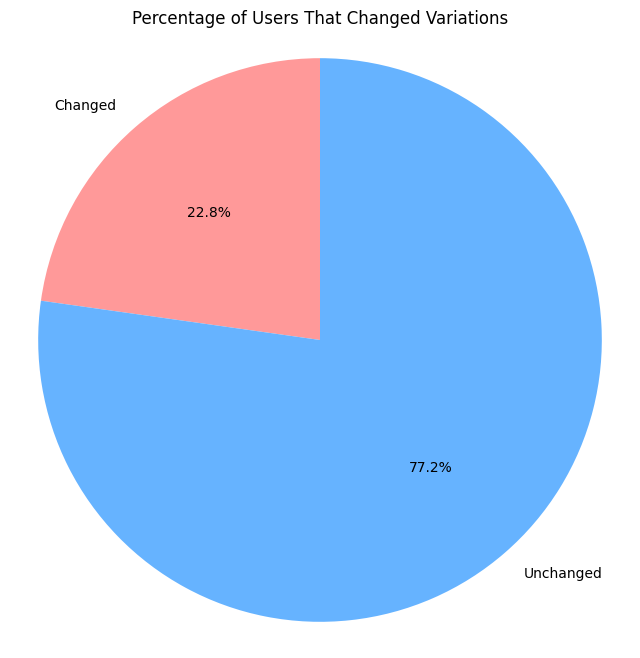


Detailed view of users that changed variations:
                                     key    value_x  value_y
5   fb0bd7dc-e91f-486e-93f9-21bef52eab1c  Treatment  Control
6   8934d42e-f630-4be5-a488-67d6cc9a1c95  Treatment  Control
14  fb68ba3f-34cc-40a0-ae18-c793275c97d4  Treatment  Control
16  dcb1e945-fc0d-4415-bf34-e0bab3a17313  Treatment  Control
23  44cccf8b-f3a4-47a9-bd8a-12ac1a653760  Treatment  Control
26  839a2a38-99d1-4127-a6f7-87f718c4253b  Treatment  Control
32  8475c913-b0ba-4764-9e29-7fcb79afac3f  Treatment  Control
40  8c0db700-0687-4795-aeb2-7c6c72e25268  Treatment  Control
42  db1bc09d-000f-42ae-a40c-f09a0c046607  Treatment  Control
44  19112843-4f36-4da3-a017-25c415634234  Treatment  Control
51  fe7eb690-9a45-4439-990b-c85f4084f6ec  Treatment  Control
52  2d7200de-eb42-44d6-af46-66471c410446  Treatment  Control
56  12f4fafc-0fa7-4865-831f-26a85ff0e890  Treatment  Control
58  0fd0bfc5-2d62-41f6-aed1-389971acb09e  Treatment  Control
67  7baef44d-2fbf-4620-9bd3-99efee3b

In [11]:
# Visualization 3: Change Summary Pie Chart
plt.figure(figsize=(8, 8))
labels = ['Changed', 'Unchanged']
sizes = [mismatchCount, num_records + 1 - mismatchCount]
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Percentage of Users That Changed Variations')
plt.show()

# Display detailed mismatch information
print("\nDetailed view of users that changed variations:")
print(mismatch[['key', 'value_x', 'value_y']])